# Projet Série Temporelles
*AHOUMENOU Onel, DEVIGNAC Vladimir, DURAND Arnaud*

## Packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## Introduction

Dans ce projet, nous allons illustrer sur un jeu de données concret les méthodes étudiées au cours. Nos données proviennent du site kaggle https://www.kaggle.com/datasets/aminesnoussi/air-pollution-dataset. Il traite de la pollution de l'air à Pekin entre le 01 Janvier 2010 et le 31 Décembre 2014.

  L'objectif est donc de prédire la pollution futur à l'aide des données passées en suivant le plan suivant:

1. [Pré-traitement des données](#partie1)
2. [Gestion de la non-stationnarité](#partie2)
3. [Identification du modèle probabiliste](#partie3)
4. [Estimation des paramètres du modèle](#partie4)
5. [Prédiction des valeurs futures](#partie5)
6. [Evaluation de la précision de prédiction](#partie6)

## Pré-traitement des données <a id="partie1"></a>

### Analyse de la base de données

    

In [9]:
# Importation des données

data = pd.read_csv("air_pollution.csv", index_col='date', parse_dates=True)
data.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


### Isolation de la variable cible "pollution_today"

In [11]:
pollution = data['pollution_today']

In [12]:
# Nombre de valeurs manquantes

pollution.isna().sum()

0

Il n'y a aucune valeur manquantes donc pas aucune valeur à estimer avant de commencer le traitement des données

In [14]:
#  Quelques statistiques utiles

pollution.describe()

count    1825.000000
mean       98.245080
std        76.807697
min         3.166667
25%        42.333333
50%        79.166667
75%       131.166667
max       541.895833
Name: pollution_today, dtype: float64

### Affichage de la série temporelle

Afin de faciliter nos analyses tout en gardant une quantité de données satisfaisante, nous allons travailler sur des moyennes de 5 jours

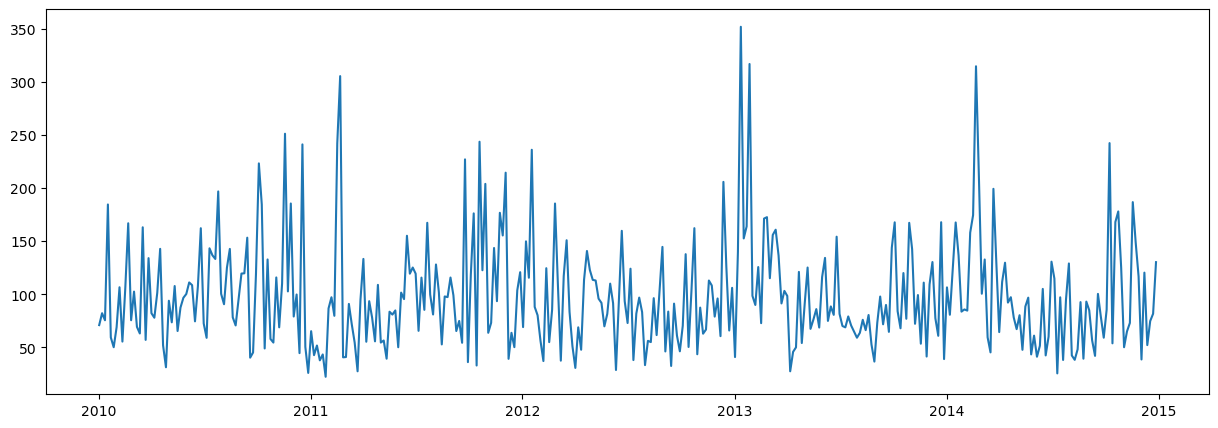

In [16]:
# Rééchantillonage sur 5 jours
y = pollution.resample('5D').mean()
x = y.index

plt.figure(figsize=(15, 5))
plt.plot(x,y)

Nous allons entrainer le(s) futur(s) modèle(s) sur les données de 2010 à 2013 inclus et procéder à l'évalution du(des) dit(s) modèle(s) sur les données de 2014.

In [18]:
# Données d'apprentissage
X_train = y['2010':'2013'].index
y_train = np.array(y['2010':'2013'])

# Données de test
X_test = y['2014'].index
y_test = np.array(y['2014':])

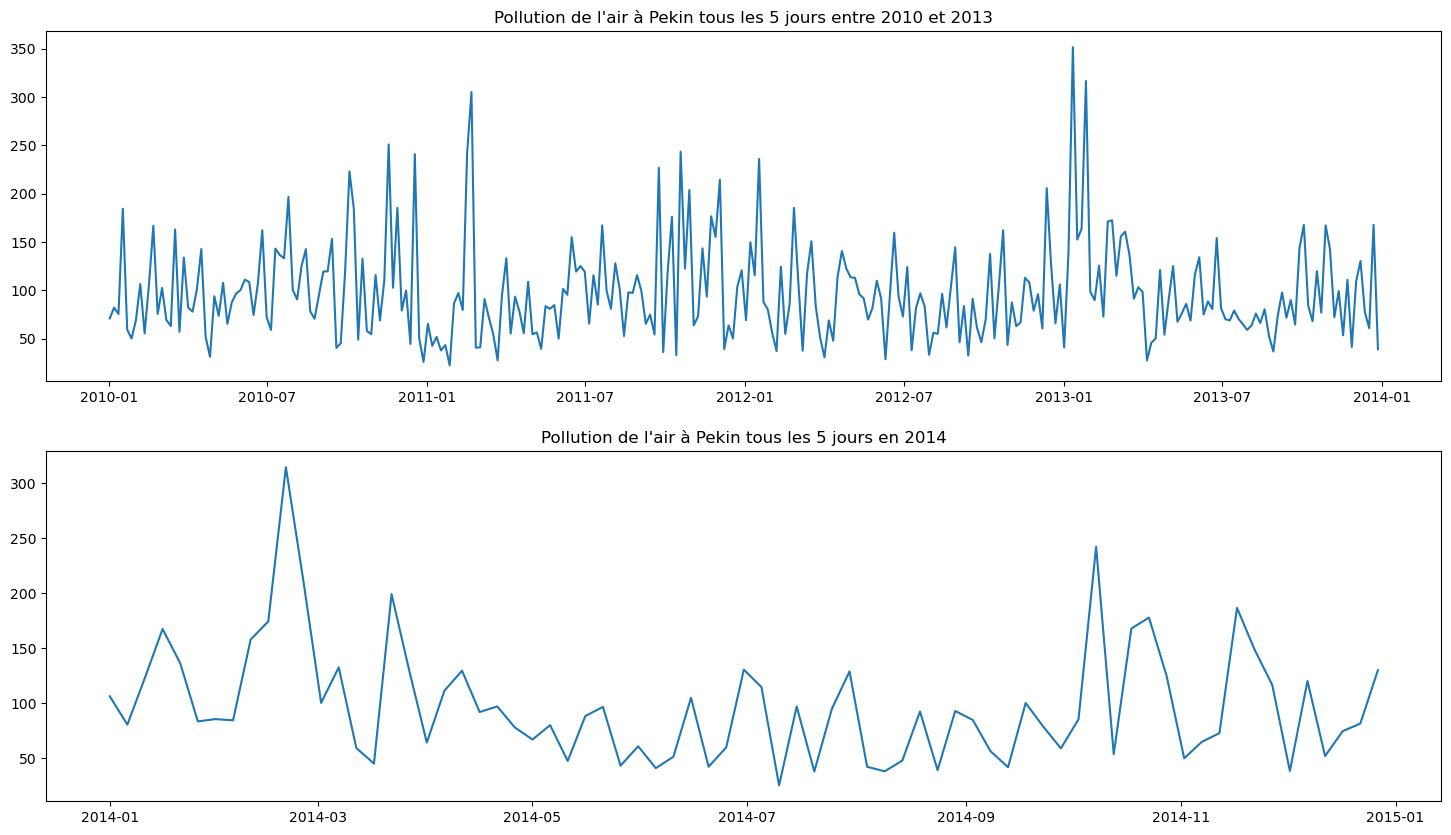

In [19]:
plt.figure(figsize=(18, 10))
plt.subplot(211)
plt.plot(X_train, y_train)
plt.title("Pollution de l'air à Pekin tous les 5 jours entre 2010 et 2013")

plt.subplot(212)
plt.plot(X_test, y_test)
plt.title("Pollution de l'air à Pekin tous les 5 jours en 2014")
plt.show()

## Gestion de la non-stationnarité <a id="partie2"></a>

### Estimation de la saisonnalité

Nous allons eliminer la saisonnalité à l'aide d'une moyenne mobile d'ordre 73 (5*73 = 365 pour 365 jours par an)

In [21]:
def moving_average(x, p):
    x.shape = len(x)
    return np.convolve(x, np.ones(p), "valid") / p

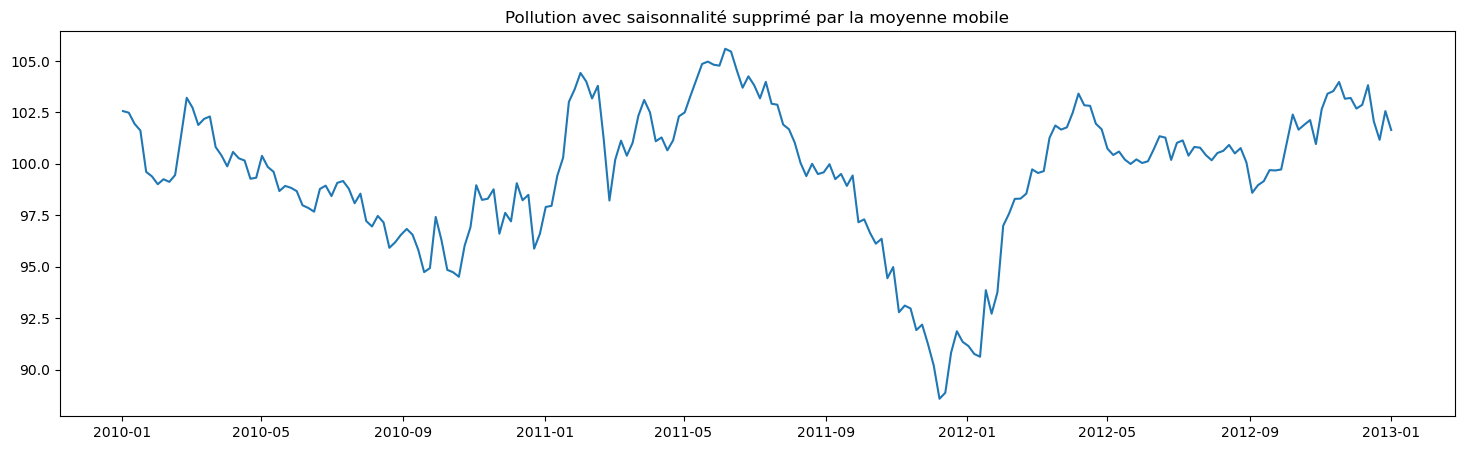

In [22]:
p = 73  # période de la moyenne mobile

y_train_sans_saison = moving_average(y_train, 73)
x_train_sans_saison = X_train[0:len(y_train_sans_saison)]

plt.figure(figsize=(18, 5))
plt.plot(x_train_sans_saison,y_train_sans_saison)
plt.title("Pollution avec saisonnalité supprimé par la moyenne mobile")
plt.show()

Nous allons determiner les coefficients de saisonnalité centrés.

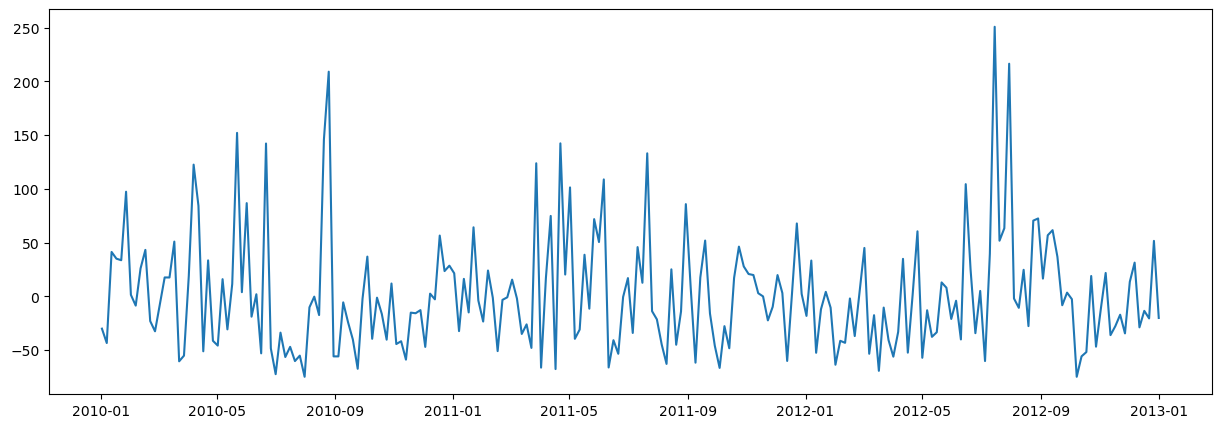

In [53]:
# On retire aux valeurs de bases les valeurs dénuées de saisonnalités
serie_corrigee = y_train[(p-1)//2:-(p-1)//2] - y_train_sans_saison

# Moyenne pour chaque mois des valeurs de saisonnalités
saisonnalite = [np.mean([serie_corrigee[j] for j in range(0, len(y_train_sans_saison)) if j%p == i]) for i in range(p)]

# Vérification que la saisonnalité est nulle sur une année
moy = np.mean(saisonnalite)
for i in range(len(saisonnalite)):
    saisonnalite[i] = saisonnalite[i] - moy
sum(saisonnalite)

plt.figure(figsize=(15,5))
plt.plot(X_train[0:len(serie_corrigee)],serie_corrigee)

**On a bien une saisonnalité annuelle nulle**

Text(0.5, 1.0, 'Saisonnalité par an')

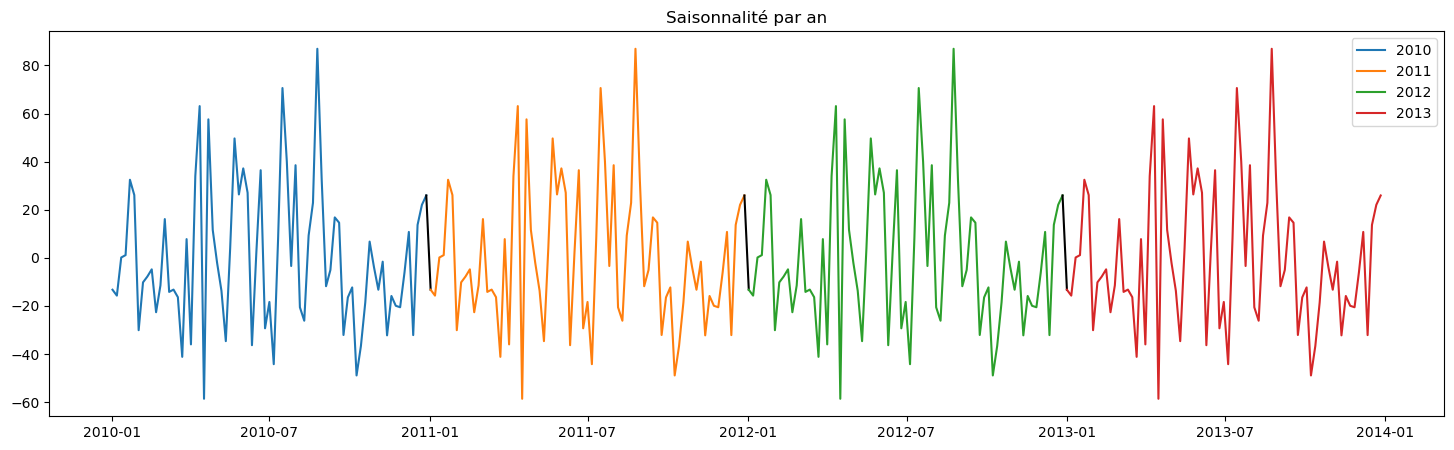

In [26]:
saison = []
rep_n = 0
while len(saison) != len(y_train):
    saison.append(saisonnalite[rep_n%p])
    rep_n += 1
df_saison = pd.DataFrame(saison, columns=["saison"])

plt.figure(figsize=(18,5))
plt.plot(X_train[0:73],df_saison["saison"][0:73],label="2010")
plt.plot(X_train[72:74],df_saison["saison"][72:74],c="black")

plt.plot(X_train[73:146],df_saison["saison"][73:146],label="2011")
plt.plot(X_train[145:147],df_saison["saison"][145:147],c="black")

plt.plot(X_train[146:219],df_saison["saison"][146:219],label="2012")
plt.plot(X_train[218:220],df_saison["saison"][218:220],c="black")

plt.plot(X_train[219:292],df_saison["saison"][219:292],label="2013")
plt.legend()
plt.title("Saisonnalité par an")

### Estimation de la tendance

Text(0.5, 1.0, 'Pollution avec saisonnalité retiré')

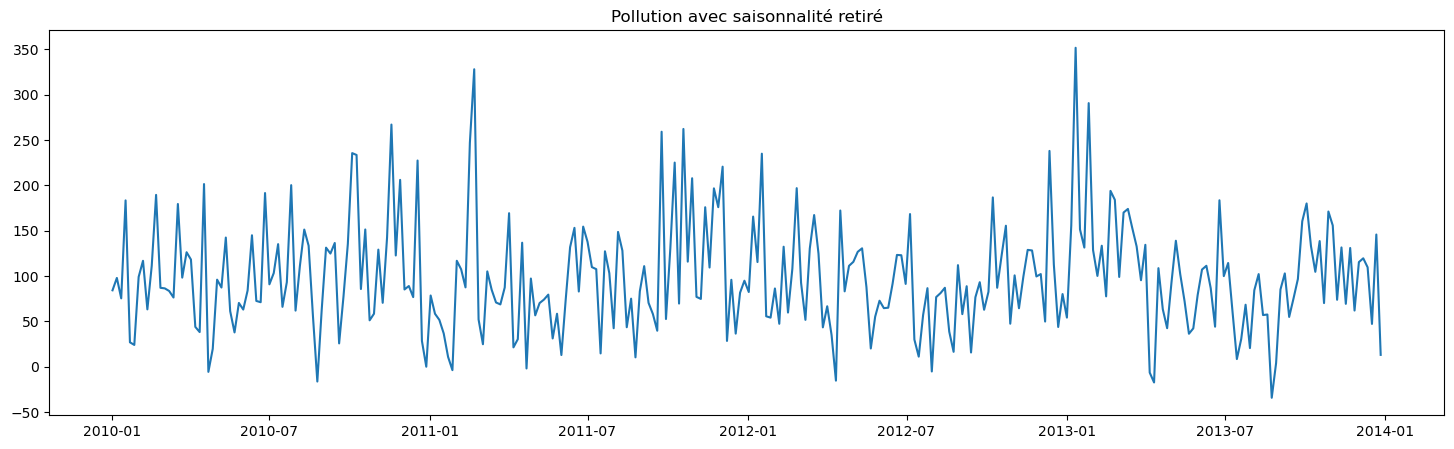

In [28]:
#On retire aux données de bases la saisonnalité
tendance = y_train - saison

df_tendance = pd.DataFrame(tendance, columns=["tendance"])
plt.figure(figsize=(18, 5))
plt.plot(X_train,df_tendance["tendance"])
plt.title("Pollution avec saisonnalité retiré")

### Modelisation de la tendance

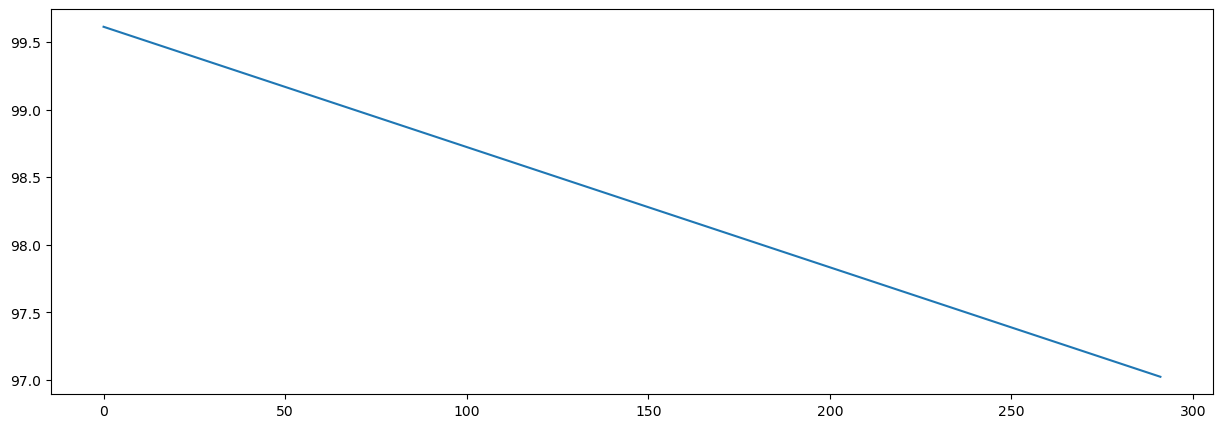

In [30]:
X = pd.DataFrame(np.array([i for i in range(len(pollution.resample('5D').mean()))]), 
                 index=data.resample('5D').mean().index, columns=['X'])
X_t= np.array(X['2010':'2013'])

modele_tendance = LinearRegression().fit(X_t,tendance)
fitted_values = modele_tendance.predict(X_t)
plt.figure(figsize=(15,5))
plt.plot(fitted_values)

### Calcul et standartisation des résidus

Text(0.5, 1.0, 'Résidus standardisés')

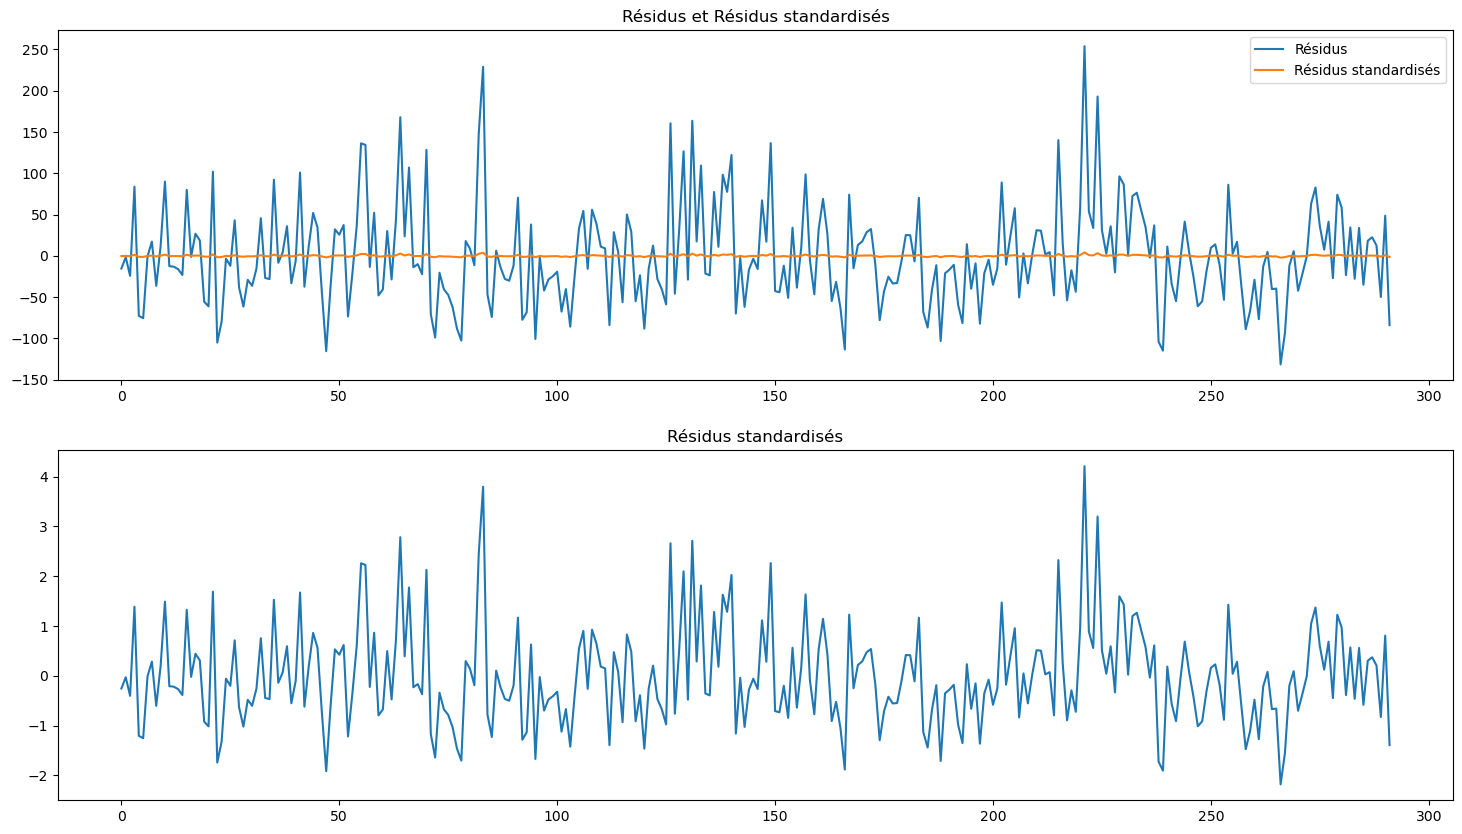

In [32]:
# On calcul les résidus en retirant des données la tendance et la saisonnalité
residus = y_train - saison - fitted_values
residus.shape = (len(residus), 1) #Même changement de dimension de précédemment

# Standartisation des résidus: on retire la moyenne et divise par la variance
residus_standards = StandardScaler().fit_transform(residus)

# Visualisation
plt.figure(figsize=(18,10))

plt.subplot(211)
plt.plot(residus,label="Résidus")
plt.plot(residus_standards,label="Résidus standardisés")
plt.legend()
plt.title("Résidus et Résidus standardisés")

#On affiche les résidus standardisés seuls afin que leur graphe soit plus visible
plt.subplot(212)
plt.plot(residus_standards)
plt.title("Résidus standardisés")

### Test de stationnarité: test de Dickey-Fuller
L'hypothèse nulle de ce test est que la série n'est pas stationnaire.

On rentre les données et le type de régréssion: ici cct signifie que l'on a des constantes, une tendance linéaire et une composante quadratique

In [34]:
adfuller(y_train, regression="ctt")

(-8.087982825619694,
 2.0418627174046147e-10,
 2,
 289,
 {'1%': -4.411670279354562,
  '5%': -3.852979391736177,
  '10%': -3.565988982259978},
 2945.1802429717404)

#### Inteprétation des résulats :

La variable nous intéréssant est celle de la deuxième ligne: c'est la P-valeur du test. Celle-ci étant pratiquement nulle, on rejete l'hypothèse de non stationnarité.

La série obtenue est donc bien stationnaire

## Identification du modèle probabiliste <a id=partie3></a>

### Analyse de l'auto correlation

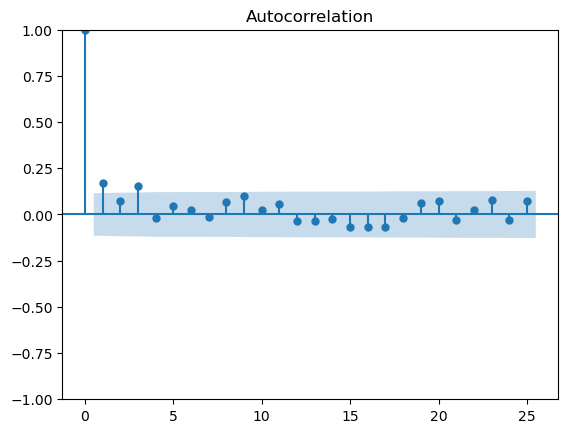

In [38]:
plot_acf(residus_standards)
plt.show()

On observe qu'un modèle MA(3) serait adapté à nos données

### Analyse de l'auto correlation partielle

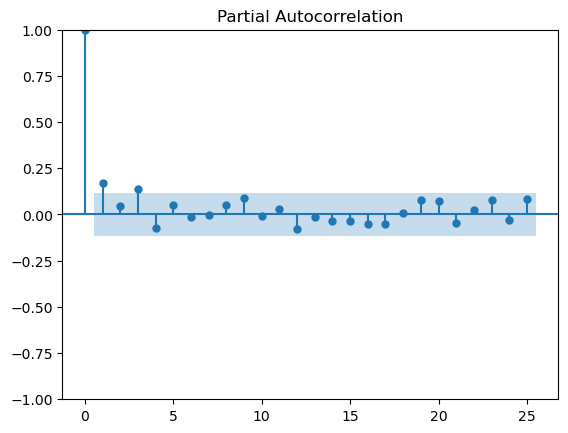

In [41]:
plot_pacf(residus_standards, method='ywm')
plt.show()

On observe qu'un modèle AR(3) serait adapté à nos données

**Nous décidons donc de choisir pour modèle probabiliste le modèle ARMA(3,3).**

## Estimation des paramètres du modèle <a id=partie4></a>

In [45]:
modele_arma33 = ARIMA(endog=y_train, order=(3, 0, 3)).fit()
parametres = modele_arma33.params
parametres

array([ 9.82632686e+01, -2.70266709e-01,  2.93870302e-01, -1.14151239e-01,
        4.02951502e-01, -2.31024178e-01,  2.15324171e-01,  2.44358930e+03])

In [46]:
modele_arma33.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1553.423
Date:                Tue, 17 Dec 2024   AIC                           3122.847
Time:                        17:34:25   BIC                           3152.261
Sample:                             0   HQIC                          3134.629
                                - 292                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.2633      4.810     20.429      0.000      88.836     107.691
ar.L1         -0.2703      0.729     -0.371      0.711      -1.700       1.159
ar.L2          0.2939      0.438      0.672      0.502      -0.564       1.152
ar.L3         -0.1142      0.516     -0.221      0.825      -1.126       0.898
ma.L1          0.4030      0.730      0.552      0.581      -1.027       1.833
ma.L2         -0.2310      0.493     -0.469      0.639      -1.197       0.735
ma.L3          0.2153      0.512      0.421      0.674      -0.788       1.218
sigma2      2443.5893    160.588     15.217      0.000    2128.843    2758.335
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               244.00
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             1.44
Prob(H) (two-sided):                  0.35   Kurtosis:                         6.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prédiction des valeurs futures <a id=partie5></a>

In [48]:
modele_arma33.predict(start='2013-12-27',end='2014-12-27')

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

## Evaluation de la précision de prédiction <a id=partie6></a>